In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# Import library

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

# numpy untuk membuat variable hexa,
# variable hexa adalah variable independent yang mempengaruhi variable dependent
# disini akan menggunakan angka acak. namun di data sebenarnya adalah data yg relate
# misalkan yang relate dengan sales adalah stok produk, jumlah promosi, dll


In [42]:
# Import Data from kaggle
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SARIMAX/Tabel Positifvity Rate Hasil Lab Covid19_DKI Jakarta.xlsx',
                     skiprows=3)
data = data.dropna(how='any')
data = data.drop(['Total spesimen di tes', 'Positif', 'Negatif', 'Positif rate (specimen harian)'], axis=1)
data.head()

,Tanggal,Tahun,Jumlah orang di tes,Orang Positif Harian,Orang negatif harian,Positif rate kasus baru harian
0,03/10/,2021.0,13384,149.0,13235.0,0.011
2,02/10/,2021.0,17832,127.0,17705.0,0.007
4,01/10/,2021.0,18445,155.0,18290.0,0.008
6,30/09/,2021.0,18240,151.0,18089.0,0.008
8,29/09/,2021.0,17365,149.0,17216.0,0.009


In [43]:
# rename column
data = data.rename(columns={'Jumlah orang di tes':'Tes', 
                            'Orang Positif Harian':'Positif',
                            'Orang negatif harian':'Negatif',
                            'Positif rate kasus baru harian':'Positif Rate'})

In [45]:
data['Tahun'] = data['Tahun'].astype(int)
data['Tahun'] = data['Tahun'].astype(str)
data['Datetime'] = data['Tanggal'] + data['Tahun']
data = data.drop(['Tahun', 'Tanggal'], axis=1)
data.head()

,Tes,Positif,Negatif,Positif Rate,Datetime
0,13384,149.0,13235.0,0.011,03/10/2021
2,17832,127.0,17705.0,0.007,02/10/2021
4,18445,155.0,18290.0,0.008,01/10/2021
6,18240,151.0,18089.0,0.008,30/09/2021
8,17365,149.0,17216.0,0.009,29/09/2021


In [47]:
# convert to datetime
data['Datetime'] = pd.to_datetime(data.Datetime, format='%d/%m/%Y')

In [81]:
data.dtypes

Tes          int64
Positif    float64
Forcast    float64
dtype: object

In [50]:
data = data.sort_values(by='Datetime', ascending=True)
data = data.set_index(data['Datetime'])
data.head()

,Tes,Positif,Negatif,Positif Rate,Datetime
Datetime,,,,,
2020-02-29,40,0.0,40.0,0.0,2020-02-29
2020-03-01,39,0.0,39.0,0.0,2020-03-01
2020-03-02,3,0.0,3.0,0.0,2020-03-02
2020-03-03,15,3.0,12.0,0.2,2020-03-03
2020-03-04,7,0.0,7.0,0.0,2020-03-04


In [80]:
data['Tes'] = data['Tes'].astype(int)

- Variable dependent (yang akan dicari) adalah angka positif
- Variable independentnya adalah jumlah yang dites
- sehingga yang lain akan di drop (negatif, positif rate, datetime)

In [52]:
data = data.drop(['Negatif', 'Positif Rate', 'Datetime'], axis=1)

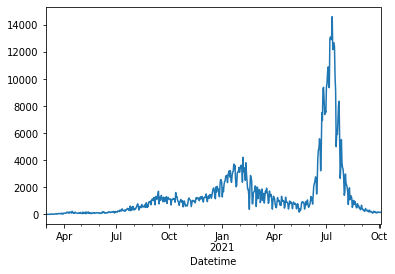

In [51]:
data['Positif'].plot()

## Modeling and Predicting

In [55]:
# Uji stationaritas

uji = sm.tsa.adfuller(data['Positif'])
print('p-value:{}'.format(uji[1]))
# alpha = 5%. 
# Jika p-value diatas itu maka belum stationer. Jika sudah dibawah 5%a atau 0.05 maka stationer

p-value:0.004331050177341334


- jika belum stationer, maka perlu dilakukan diferencing 
- dengan mengurangkan nilai waktu sekarang dengan waktu sebelumnya
- lalu hilangkan miss valuenya, karena waktu pertama tidak ada pengurangnya

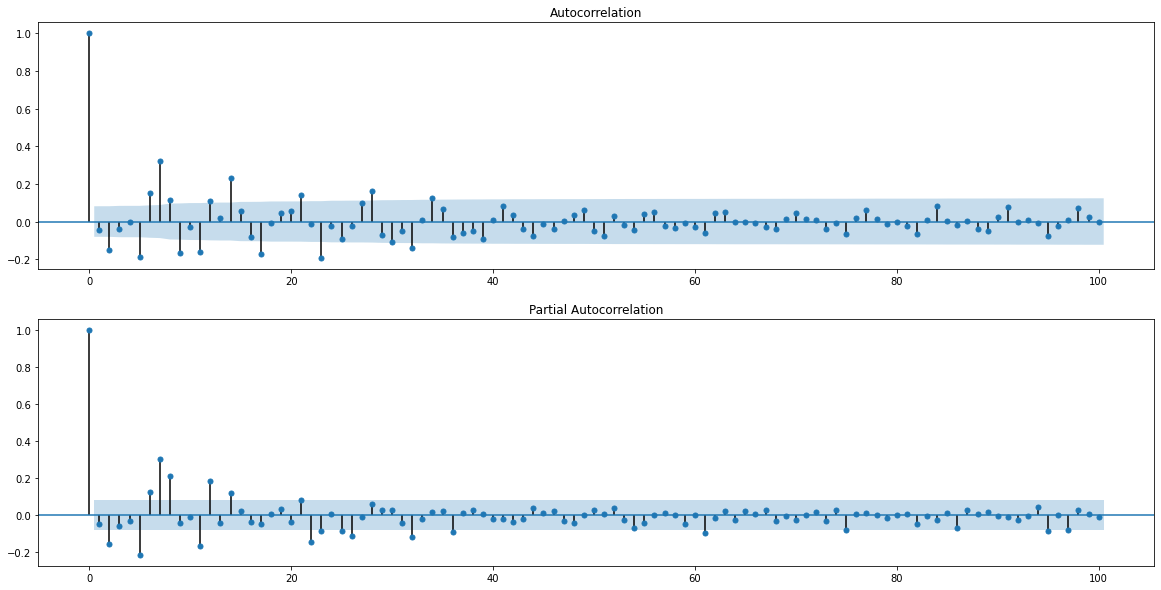

In [59]:
# mencari paramater p dengan menggunakan acf
# mencari paramater q dengan menggunakan pacf

fig, ax = plt.subplots(2,1, figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(data['Positif'].diff().dropna(), lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(data['Positif'].diff().dropna( ), lags=100, ax=ax[1])
plt.show()

In [86]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data['Positif'],
              order=(6,1,6),
              seasonal_orders=(1,1,18),
              exog=data['Tes'])

In [87]:
res = model.fit(disp=False)

In [88]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                Positif   No. Observations:                  583
Model:               SARIMAX(6, 1, 6)   Log Likelihood               -4340.274
Date:                Thu, 04 Nov 2021   AIC                           8708.547
Time:                        06:09:24   BIC                           8769.678
Sample:                    02-29-2020   HQIC                          8732.377
                         - 10-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Tes            0.0809      0.007     11.377      0.000       0.067       0.095
ar.L1          0.7862      0.064     12.302      0.000       0.661       0.911
ar.L2         -0.2474      0.083     -2.980      0.003      -0.410      -0.085
ar.L3         -0.4237      0.071     -5.929      0.000      -0.564      -0.284
ar.L4          0.4760      0.093      5.108      0.000       0.293       0.659
ar.L5         -0.3500      0.096     -3.639      0.000      -0.538      -0.161
ar.L6          0.4619      0.068      6.804      0.000       0.329       0.595
ma.L1         -0.9099      0.073    -12.415      0.000      -1.054      -0.766
ma.L2          0.1602      0.118      1.361      0.174      -0.071       0.391
ma.L3          0.6110      0.098      6.223      0.000       0.419       0.803
ma.L4         -0.5411      0.106     -5.103      0.000      -0.749      -0.333
ma.L5          0.1187      0.136      0.874      0.382      -0.147       0.385
ma.L6         -0.0696      0.095     -0.736      0.462      -0.255       0.116
sigma2      1.934e+05   7280.966     26.569      0.000    1.79e+05    2.08e+05
===================================================================================
Ljung-Box (Q):                       73.01   Jarque-Bera (JB):              3214.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              31.09   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

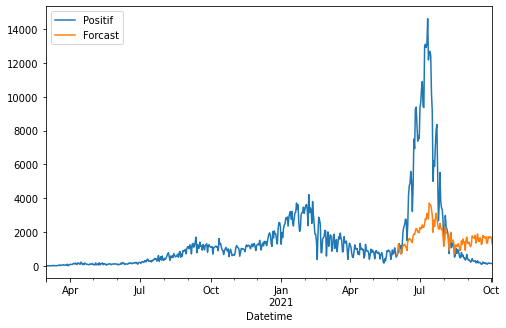

In [89]:
data['Forcast'] = res.predict(start='2021-06-01', 
                              end='2021-10-03',
                              dynamic=True)
data[['Positif', 'Forcast']].plot(figsize=(8,5))